In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

import re
import nltk
nltk.download('punkt')
nltk.download('wordnet')
import string
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve,auc
from nltk.stem.porter import PorterStemmer
# Tutorial about Python regular expressions: https://pymotw.com/2/re/
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer
from gensim.models import word2vec
from gensim.models import KeyedVectors
import pickle

from tqdm import tqdm
import os
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, classification_report
from sklearn.model_selection import GridSearchCV, StratifiedKFold

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\DELL\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\DELL\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [2]:
data = pd.read_csv("Modified_SQL_Dataset.csv")

In [3]:
data.dropna(inplace=True)
stopwords= set(['br', 'the', 'i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've",\
            "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', \
            'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their',\
            'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', \
            'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', \
            'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', \
            'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after',\
            'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further',\
            'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more',\
            'most', 'other', 'some', 'such', 'only', 'own', 'same', 'so', 'than', 'too', 'very', \
            's', 't', 'can', 'will', 'just', 'don', "don't", 'should', "should've", 'now', 'd', 'll', 'm', 'o', 're', \
            've', 'y', 'ain', 'aren', "aren't", 'couldn', "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn',\
            "hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn', "isn't", 'ma', 'mightn', "mightn't", 'mustn',\
            "mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', "weren't", \
            'won', "won't", 'wouldn', "wouldn't"])

In [4]:

from tqdm import tqdm
preprocessed_query = []
lemmatizer = WordNetLemmatizer()
# tqdm để hiển thị thanh trạng thái
for sentance in tqdm(data['Query'].values):
    sentance = re.sub('[^A-Za-z0-9]+', ' ', sentance)
    sentance = re.sub(r',', ' ', sentance)
    #https://www.machinelearningplus.com/nlp/lemmatization-examples-python/
    tokenization = nltk.word_tokenize(sentance)
    sentance = ' '.join([lemmatizer.lemmatize(w) for w in tokenization])
    # https://gist.github.com/sebleier/554280
    sentance = ' '.join(e.lower() for e in sentance.split() if e.lower() not in stopwords)
    preprocessed_query.append(sentance.strip())

100%|██████████| 30919/30919 [00:04<00:00, 6918.38it/s] 


In [5]:
preprocessed_query

['pg sleep time',
 'create user name identified pass123 temporary tablespace temp default tablespace user',
 '1 utl inaddr get host address select distinct table name select distinct table name rownum limit sys table limit 5',
 'select user id 1 1 1 union select 1 version 1',
 'select user id 1 1 union select 1 version 1',
 'select name syscolumns id select id sysobjects name tablename',
 'select user id 1 1 1 1',
 '1 load file char 47 101 116 99 47 112 97 115 115 119 100 1 1 1',
 'select user id 1 1 1 union select 1 version 1',
 'select user id 1 union select 1 version 1',
 '1 1',
 '',
 'admin 1 1',
 'select user id 1 1 1 1',
 '1 1',
 '1 utl inaddr get host address select distinct column name select distinct column name rownum limit tab column limit 5',
 'select user id 1 union select 1 version 1',
 'select user id 1 1 1 1',
 'select user id 1 1 1 1',
 'distinct',
 'select user id 1 1 1 1',
 '1 ascii lower substring select top 1 name sysobjects xtype u 1 1 116',
 'select user id 1 1 1

In [6]:
data['Query'] = preprocessed_query
data.head()

,Query,Label
0,pg sleep time,1
1,create user name identified pass123 temporary ...,1
2,1 utl inaddr get host address select distinct ...,1
3,select user id 1 1 1 union select 1 version 1,1
4,select user id 1 1 union select 1 version 1,1


In [7]:
# Chuyển đổi thành Bag of Words (BoW)
count_vect = CountVectorizer(ngram_range=(1, 1))
X_train_counts = count_vect.fit_transform(preprocessed_query)

# Lấy tên các đặc trưng
feature_names = count_vect.get_feature_names_out()
print(f"Feature names (first 10): {feature_names[:10]}")
print(f"Shape of the feature matrix: {X_train_counts.shape}")



Feature names (first 10): ['00' '000001' '000003' '000004' '000023' '000045' '00033926r' '00041731d'
 '00207473j' '00217e']
Shape of the feature matrix: (30919, 24462)


In [8]:

X = X_train_counts
y = data['Label']  
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [9]:
print(f"X_train shape: {X_train.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"y_test shape: {y_test.shape}")

X_train shape: (24735, 24462)
X_test shape: (6184, 24462)
y_train shape: (24735,)
y_test shape: (6184,)


<h3> Áp dụng SVM </h3>

In [10]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import GridSearchCV

In [22]:
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Define the SVM model and hyperparameter grid
svm_parameters = {
    'C': [0.1, 1, 10, 100],
    'kernel': ['linear', 'rbf', 'poly']

}
svm = SVC()

# Set up GridSearchCV with 5-fold cross-validation
grid = GridSearchCV(estimator=svm, param_grid=svm_parameters, scoring='accuracy', verbose=1, cv=5)
grid.fit(X_train, y_train)

# Output the best score and parameters
print("Best Score: " + str(grid.best_score_))
print("Best Parameters: " + str(grid.best_params_))


Fitting 5 folds for each of 12 candidates, totalling 60 fits
Best Score: 0.9573074590661006
Best Parameters: {'C': 10, 'kernel': 'rbf'}


In [23]:
svm_results = pd.DataFrame(grid.cv_results_)
svm_results_summary = svm_results[['param_C', 'param_kernel', 'mean_test_score', 'std_test_score']]
svm_results_summary_sorted = svm_results_summary.sort_values(by='mean_test_score', ascending=False)
print(svm_results_summary_sorted)


   param_C param_kernel  mean_test_score  std_test_score
7       10          rbf         0.957307        0.001664
10     100          rbf         0.952254        0.002545
6       10       linear         0.945866        0.003293
4        1          rbf         0.945381        0.003109
3        1       linear         0.930220        0.005244
0      0.1       linear         0.927431        0.009345
1      0.1          rbf         0.921771        0.004529
11     100         poly         0.909561        0.005572
8       10         poly         0.890439        0.005229
5        1         poly         0.851708        0.005219
2      0.1         poly         0.794259        0.005378
9      100       linear         0.779139        0.007592


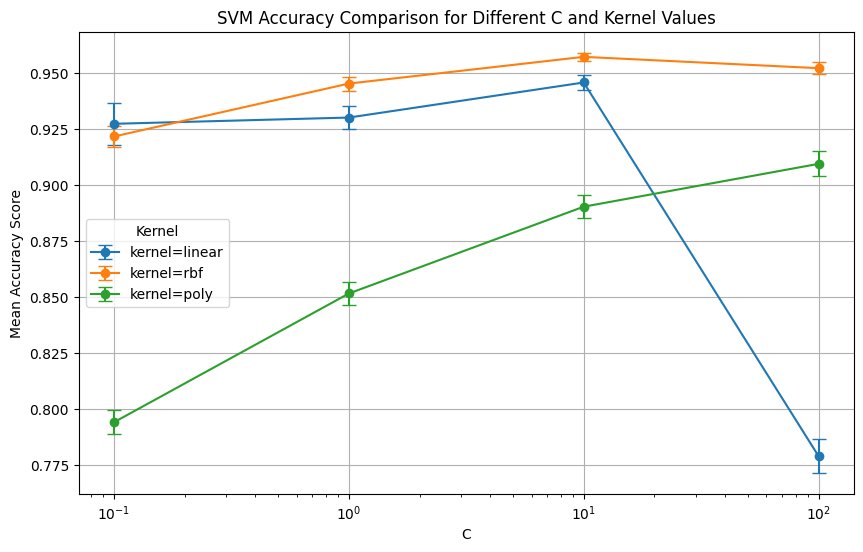

In [24]:
plt.figure(figsize=(10, 6))
for kernel in ['linear', 'rbf', 'poly']:
    subset = svm_results_summary[svm_results_summary['param_kernel'] == kernel]
    plt.errorbar(subset['param_C'], subset['mean_test_score'], yerr=subset['std_test_score'],
                 fmt='-o', capsize=5, label=f'kernel={kernel}')
plt.xlabel('C')
plt.ylabel('Mean Accuracy Score')
plt.title('SVM Accuracy Comparison for Different C and Kernel Values')
plt.xscale('log')  # Use logarithmic scale for C to better visualize differences
plt.legend(title='Kernel')
plt.grid(True)
plt.show()

Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.99      0.97      3893
           1       0.99      0.90      0.94      2291

    accuracy                           0.96      6184
   macro avg       0.97      0.95      0.96      6184
weighted avg       0.96      0.96      0.96      6184



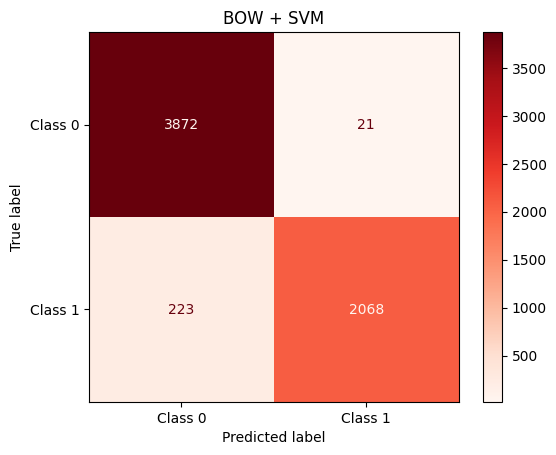

In [25]:
# Make predictions on the test set
y_pred = grid.predict(X_test)

# Confusion matrix and classification report
conf_matrix_svm = confusion_matrix(y_test, y_pred)
print("Classification Report:")
print(classification_report(y_test, y_pred))


# Plot the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix_svm, display_labels=['Class 0', 'Class 1'])
disp.plot(cmap='Reds')
plt.title('BOW + SVM')
plt.show()


<h3> Áp dụng NB </h3>

Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best Score: 0.951809177279159
Best Parameters: {'alpha': 0.01, 'fit_prior': False}
  param_alpha param_fit_prior  mean_test_score  std_test_score
1        0.01           False         0.951809        0.003154
0        0.01            True         0.951486        0.003272
3         0.1           False         0.950839        0.003117
2         0.1            True         0.949303        0.003318
7        10.0           False         0.946270        0.001902
5         1.0           False         0.945583        0.003088
4         1.0            True         0.941015        0.004353
6        10.0            True         0.933657        0.002880


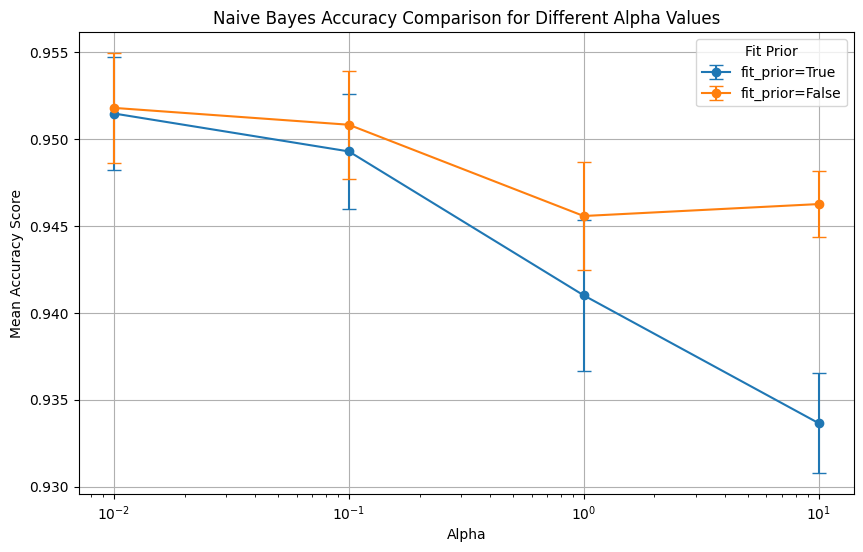

In [15]:
from sklearn.naive_bayes import MultinomialNB

# Define the NB model and hyperparameter grid
nb_parameters = {
    'alpha': [0.01, 0.1, 1.0, 10.0],
    'fit_prior': [True, False]
}
nb = MultinomialNB()

# Set up GridSearchCV with 5-fold cross-validation
grid = GridSearchCV(estimator=nb, param_grid=nb_parameters, scoring='accuracy', verbose=1, cv=5)
grid.fit(X_train, y_train)

# Output the best score and parameters
print("Best Score: " + str(grid.best_score_))
print("Best Parameters: " + str(grid.best_params_))

# Summarize grid search results
results_df = pd.DataFrame(grid.cv_results_)
results_summary = results_df[['param_alpha', 'param_fit_prior', 'mean_test_score', 'std_test_score']]
results_summary_sorted = results_summary.sort_values(by='mean_test_score', ascending=False)
print(results_summary_sorted)

# Plot the grid search results for Naive Bayes
plt.figure(figsize=(10, 6))
for fit_prior in [True, False]:
    subset = results_summary[results_summary['param_fit_prior'] == fit_prior]
    plt.errorbar(subset['param_alpha'], subset['mean_test_score'], yerr=subset['std_test_score'],
                 fmt='-o', capsize=5, label=f'fit_prior={fit_prior}')
plt.xlabel('Alpha')
plt.ylabel('Mean Accuracy Score')
plt.title('Naive Bayes Accuracy Comparison for Different Alpha Values')
plt.xscale('log')  # Use logarithmic scale for alpha to better visualize differences
plt.legend(title='Fit Prior')
plt.grid(True)
plt.show()


Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.98      0.97      3893
           1       0.97      0.92      0.94      2291

    accuracy                           0.96      6184
   macro avg       0.96      0.95      0.95      6184
weighted avg       0.96      0.96      0.96      6184



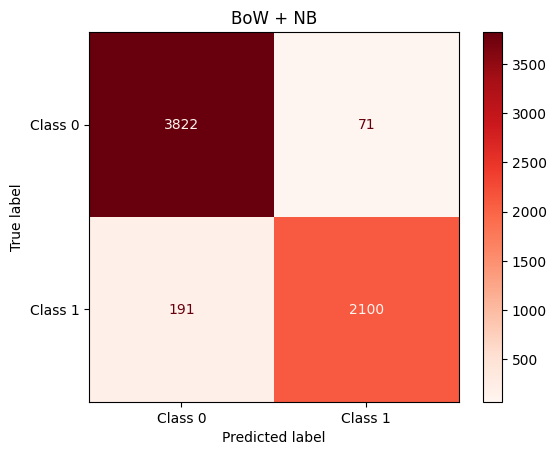

In [16]:
# Make predictions on the test set
y_pred = grid.predict(X_test)

# Confusion matrix and classification report
conf_matrix_nb = confusion_matrix(y_test, y_pred)
print("Classification Report:")
print(classification_report(y_test, y_pred))

# Plot the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix_nb, display_labels=['Class 0', 'Class 1'])
disp.plot(cmap='Reds')
plt.title('BoW + NB')
plt.show()


<h3> Áp dụng KNN </h3>

Fitting 5 folds for each of 26 candidates, totalling 130 fits
Best Score: 0.7332929047907824
Best Parameters: {'n_neighbors': 1}
   param_n_neighbors  mean_test_score  std_test_score
0                  1         0.733293        0.004173
1                  3         0.721528        0.004164
3                  6         0.714857        0.010048
2                  5         0.713523        0.011167
4                  7         0.709076        0.010595
6                  9         0.704993        0.010580
9                 12         0.701516        0.013278
5                  8         0.701476        0.013551
11                14         0.700020        0.014343
10                13         0.699656        0.012676
8                 11         0.698929        0.013702
12                15         0.698807        0.012147
7                 10         0.696948        0.014717
14                17         0.693713        0.012033
17                20         0.693026        0.012187
18     

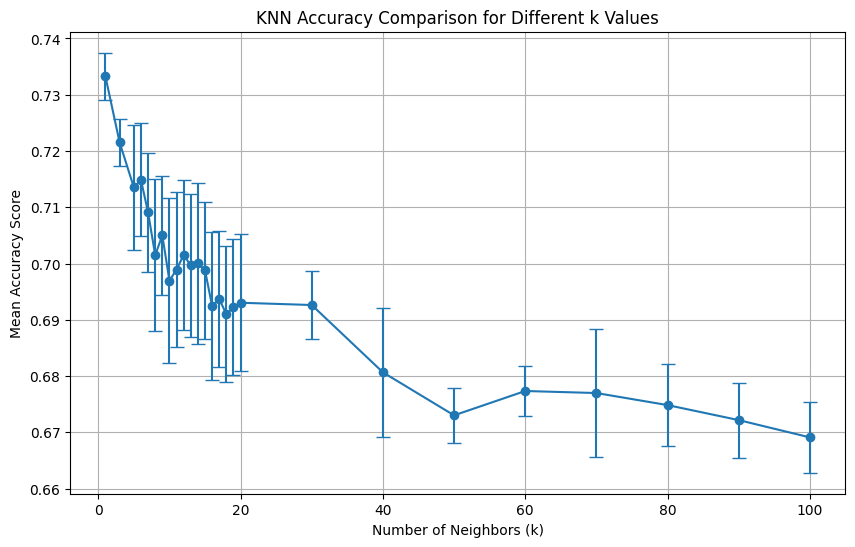

In [17]:
from sklearn.neighbors import KNeighborsClassifier

# Define the KNN model and hyperparameter grid
knn_parameters = {'n_neighbors': [1, 3, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 30, 40, 50, 60, 70, 80, 90, 100]}
knn = KNeighborsClassifier()

# Set up GridSearchCV with 5-fold cross-validation
grid = GridSearchCV(estimator=knn, param_grid=knn_parameters, scoring='accuracy', verbose=1, cv=5)
grid.fit(X_train, y_train)

# Output the best score and parameters
print("Best Score: " + str(grid.best_score_))
print("Best Parameters: " + str(grid.best_params_))

# Summarize grid search results
results_df = pd.DataFrame(grid.cv_results_)
results_summary = results_df[['param_n_neighbors', 'mean_test_score', 'std_test_score']]
results_summary_sorted = results_summary.sort_values(by='mean_test_score', ascending=False)
print(results_summary_sorted)

# Plot mean accuracy for different k values
plt.figure(figsize=(10, 6))
plt.errorbar(results_summary['param_n_neighbors'], results_summary['mean_test_score'], yerr=results_summary['std_test_score'], fmt='-o', capsize=5)
plt.xlabel('Number of Neighbors (k)')
plt.ylabel('Mean Accuracy Score')
plt.title('KNN Accuracy Comparison for Different k Values')
plt.grid(True)
plt.show()

Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.61      0.75      3893
           1       0.59      0.96      0.73      2291

    accuracy                           0.74      6184
   macro avg       0.78      0.78      0.74      6184
weighted avg       0.82      0.74      0.74      6184



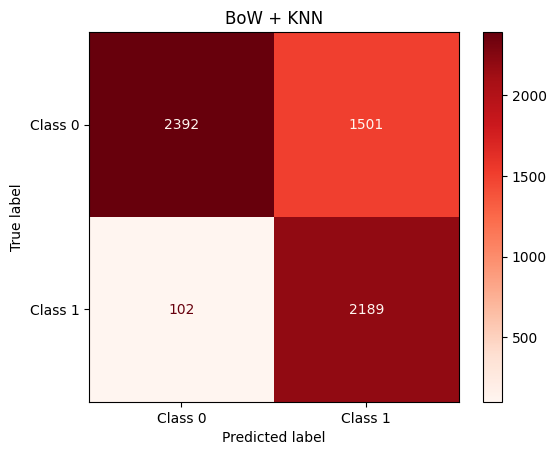

In [18]:
# Make predictions on the test set
y_pred = grid.predict(X_test)

# Confusion matrix and classification report
conf_matrix_knn = confusion_matrix(y_test, y_pred)
print("Classification Report:")
print(classification_report(y_test, y_pred))

# Plot the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix_knn, display_labels=['Class 0', 'Class 1'])
disp.plot(cmap='Reds')
plt.title('BoW + KNN')
plt.show()


<h3> Áp dụng RF </h3>

<h3> Áp dụng AdaBoost </h3>

<h3> Áp dụng XGBoost </h3>

Fitting 5 folds for each of 405 candidates, totalling 2025 fits
Best Score: 0.9387507580351728
Best Parameters: {'colsample_bytree': 1.0, 'learning_rate': 0.2, 'max_depth': 7, 'n_estimators': 200, 'subsample': 1.0}


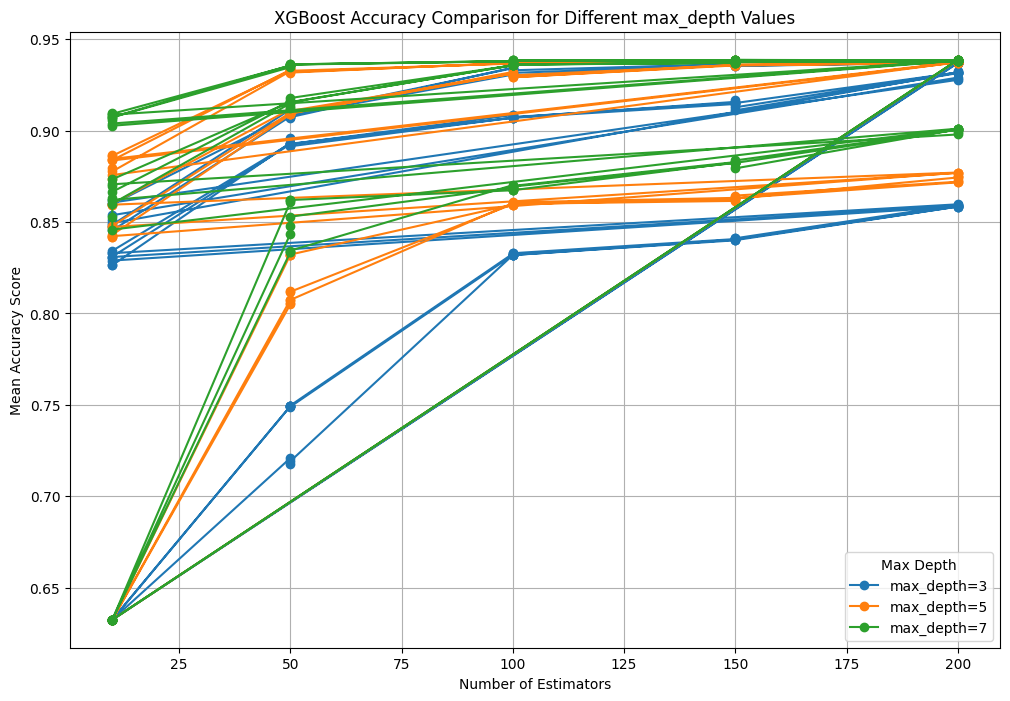

In [ ]:

from xgboost import XGBClassifier

xgb_parameters = {
    'n_estimators': [10, 50, 100, 150, 200],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1, 0.2],
    'subsample': [0.7, 0.8, 1.0],
    'colsample_bytree': [0.7, 0.8, 1.0]
}

xgb = XGBClassifier(use_label_encoder=False, eval_metric='logloss')

grid = GridSearchCV(estimator=xgb, param_grid=xgb_parameters, scoring='accuracy', verbose=1, cv=5)
grid.fit(X_train, y_train)

print("Best Score: " + str(grid.best_score_))
print("Best Parameters: " + str(grid.best_params_))

results = pd.DataFrame(grid.cv_results_)
results_summary = results[['param_n_estimators', 'param_max_depth', 'param_learning_rate',
                           'param_subsample', 'param_colsample_bytree', 'mean_test_score', 'std_test_score']]
results_summary_sorted = results_summary.sort_values(by='mean_test_score', ascending=False)


plt.figure(figsize=(12, 8))
for depth in xgb_parameters['max_depth']:
    subset = results_summary[results_summary['param_max_depth'] == depth]
    plt.plot(subset['param_n_estimators'], subset['mean_test_score'], '-o', label=f'max_depth={depth}')

plt.xlabel('Number of Estimators')
plt.ylabel('Mean Accuracy Score')
plt.title('XGBoost Accuracy Comparison for Different max_depth Values')
plt.legend(title='Max Depth')
plt.grid(True)
plt.show()

In [ ]:

results_summary_sorted

,param_n_estimators,param_max_depth,param_learning_rate,param_subsample,param_colsample_bytree,mean_test_score,std_test_score
404,200,7,0.2,1.0,1.0,0.938751,0.002979
401,150,7,0.2,1.0,1.0,0.938670,0.002820
134,200,7,0.2,1.0,0.7,0.938629,0.002809
266,150,7,0.2,1.0,0.8,0.938629,0.002820
269,200,7,0.2,1.0,0.8,0.938629,0.002820
...,...,...,...,...,...,...,...
135,10,3,0.01,0.7,0.8,0.632464,0.000081
136,10,3,0.01,0.8,0.8,0.632464,0.000081
301,10,7,0.01,0.8,1.0,0.632464,0.000081
17,10,5,0.01,1.0,0.7,0.632464,0.000081


In [20]:
y_pred = grid.predict(X_test)
conf_matrix_xgb = confusion_matrix(y_test, y_pred)
print("Classification Report:")
print(classification_report(y_test, y_pred))

Classification Report:
              precision    recall  f1-score   support

           0       0.92      0.99      0.96      3893
           1       0.98      0.86      0.92      2291

    accuracy                           0.94      6184
   macro avg       0.95      0.93      0.94      6184
weighted avg       0.94      0.94      0.94      6184



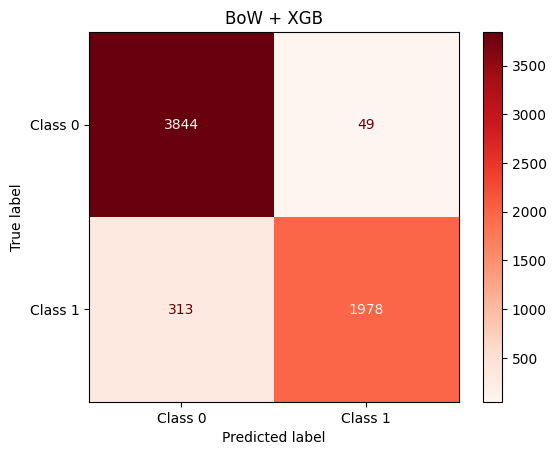

In [21]:
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix_xgb, display_labels=['Class 0', 'Class 1'])
disp.plot(cmap='Reds')
plt.title('BoW + XGB')
plt.show()
